In [7]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from setting.setting import *

In [8]:
data_dir = "../../dataset/processed/v1/training"
val_data_dir = "../../dataset/processed/v1/validation"
model_dir = "../../models/VGG16"
best_model_filename = 'vgg16_best_model_v1.keras'
os.makedirs(model_dir, exist_ok=True)

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
).map(lambda x, y: (x / 255.0, y))


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
).map(lambda x, y: (x / 255.0, y))

Found 21945 files belonging to 26 classes.
Found 2465 files belonging to 26 classes.


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.1),
])

In [11]:

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [12]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=1
)


checkpoint = ModelCheckpoint(
    os.path.join(model_dir, best_model_filename),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [15]:
final_total_epochs = 1000
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=final_total_epochs,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/1000
686/686 [==============================] - ETA: 0s - loss: 1.4198 - accuracy: 0.6227
Epoch 1: val_accuracy improved from -inf to 0.94686, saving model to ../../models/VGG16\vgg16_best_model_v1.keras
686/686 [==============================] - 226s 286ms/step - loss: 1.4198 - accuracy: 0.6227 - val_loss: 0.3699 - val_accuracy: 0.9469
Epoch 2/1000
686/686 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.8607
Epoch 2: val_accuracy improved from 0.94686 to 0.96471, saving model to ../../models/VGG16\vgg16_best_model_v1.keras
686/686 [==============================] - 141s 205ms/step - loss: 0.5704 - accuracy: 0.8607 - val_loss: 0.1930 - val_accuracy: 0.9647
Epoch 3/1000
686/686 [==============================] - ETA: 0s - loss: 0.3997 - accuracy: 0.9045
Epoch 3: val_accuracy improved from 0.96471 to 0.97039, saving model to ../../models/VGG16\vgg16_best_model_v1.keras
686/686 [==============================] - 224s 325ms/step - loss: 0.3997 - accuracy: 0.

In [16]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/VGG16\vgg16_best_model_v1.keras


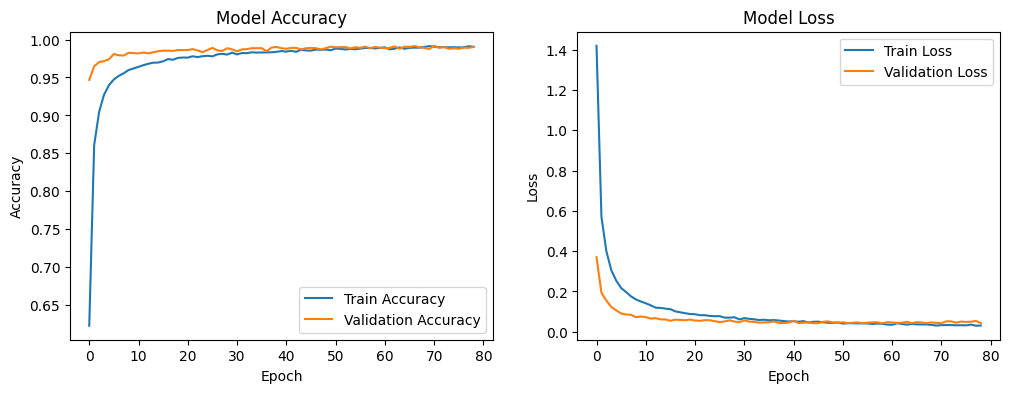

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 291ms/step


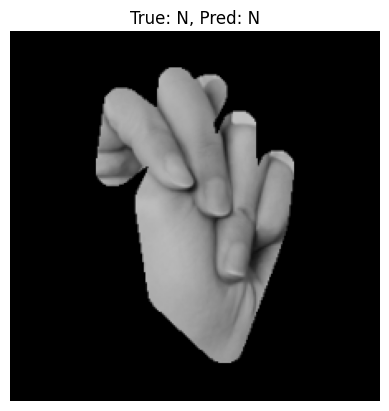

In [18]:
import random
import numpy as np
import string

val_images, val_labels = next(iter(val_ds))
random_index = random.randint(0, BATCH_SIZE - 1)
img = val_images[random_index]
true_label = val_labels[random_index]

pred = model.predict(tf.expand_dims(img, axis=0))
pred_label = string.ascii_uppercase[np.argmax(pred)]
true_label_str = string.ascii_uppercase[np.argmax(true_label)]

plt.imshow(img)
plt.title(f"True: {true_label_str}, Pred: {pred_label}")
plt.axis('off')
plt.show()